In [1]:
!pip3 install -q pandas openpyxl matplotlib scikit-learn seaborn tqdm keybert konlpy

^C
ERROR: Operation cancelled by user


# TODO
1. 중복 데이터 제거
2. 영어 -> 한국어 번역
3. 너무 많은 명사 지우기

In [321]:
import pandas as pd
pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')


In [366]:

# 인덱스를 지정해 시트 설정
df_sheet_origin = pd.read_excel('ntis_data.xlsx', sheet_name='Sheet1', engine='openpyxl')
df_sheet = df_sheet_origin.copy()
df['Title']=df['Title'].str.replace(" ","")
df_sheet.drop_duplicates(subset=['Title'], inplace = True)
print("before drop: ", df_sheet_origin.shape, "after_drop: ", df_sheet.shape)

before drop:  (2941, 11) after_drop:  (1402, 11)


In [367]:
# Field 전처리
import re

df = df_sheet.copy()

def field_preprocess(text):
    text = re.sub(' ', '', text)
    text = re.sub('[^\w\s\d가-힣.,()]', '', text)
    text = re.sub('10신규|이공분야학문후속|대학중점|이공계전문가기술개발서포터즈|주요사업비|소부장회계|운영경비|(연구)운영비지원|\(R&D\)|\(\)|0\.5|균특|일반,R&D|특별,R&D|비ODA|(개발|연구|지원|육성|구축|활용|보급)사업$' ,'', text)
    text = re.sub('21C','21세기', text)
    text = re.sub('브레인풀','BRAINPOOL', text)
    return text

df['Field'] = df['Field'].apply(lambda x: field_preprocess(x))

#print(df['Field'].value_counts(ascending=True).sort_index())

In [368]:
# Details 전처리

df['Details'] = df_sheet['Details']


def details_preprocess(text):
    text = str(text)

    # 기호 정리
    punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }
    for p in punct_mapping:
        text = text.replace(p, punct_mapping[p])
        
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    for p in punct:
        text = text.replace(p, f' {p} ')
        
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])

    # 공백 제거
    text = re.sub(' +', ' ', text)
    text = re.sub('[^\w\s가-힣\{\}\[\]\/\(\)\=\'\"\-\\?.,;:|*~`!^_+<>@\#$%&°]', '', text)
    text = re.sub('\( ', '(', text)
    text = re.sub(' \)', ')', text)    
    text = re.sub('\[ ', '[', text)
    text = re.sub(' \]', ']', text)
    text = re.sub(' \.', '.', text)
    text = re.sub('(\*\s){2,}', '* ', text)fㅏㅐㅟ

    return text

df['Details'] = df['Details'].apply(lambda x: details_preprocess(x))
# print(df['Details'])

In [440]:
# title, detail -> content에 넣고 명사 단위로 분해

from collections import Counter
from konlpy.tag import Okt
from tqdm import tqdm

#제목에 들어간 단어 개수는 2배 늘려주기
df['Contents']=df['Title']+ df['Title'] + '\n ' + df['Details'] 

# if df['Keyword'] is not None:
#     df['Contents']=df['Contents']+'\nKeyword: '+df['Keyword']

okt = Okt() # 형태소 분석기 객체 생성
noun_list = []
count = Counter()

stop_words = [
    '공학', '개발', '개선', '검증', '검토', '결과', '결합', '경우', '계산', '공간', '고려', '과정', '관련',
    '과제', '구조', '구축', '구현', '기관', '기능', '기반','기존', '기술', '기초', '년도',
    '다중', '단계', '또한', '대한', '디자인', '모드', '목표', '발생', '방법', '방향',
    '변화', '분석', '분야', '비교', '사용', '상용', '상태', '생산', '선정', '선택',
    '설계', '성능', '세부', '수행', '시간', '시뮬레이션', '시스템', '시험', '신뢰',
    '안정', '양산', '연구', '영역', '위치', '위해', '융합', '응용', '이론', '이용', '자료',
    '적용', '제어', '제작', '제품', '조건', '조사', '조성', '조절', '주관',
    '지원', '진단', '진행', '참여', '처리', '최소', '최종', '출력', '크기', '테스트', '통한',
    '통합', '통해', '특성', '평가', '포함', '프로그램', '효과', '해석', '핵심', '향상', '현상',
    '형상', '형성', '형태', '확보', '확인', '환경', '활용',
    '내용', '정보', '결정', '이하', '수준', '제안', '영향','매우', '때문', '계획','도입',
    '다음','따라서','운영','내부','대해','실제','유지','방안',
    '증가','보완','바탕','신규','파악','대상','신규','다른','달성','외부','산업','기업','한계','한국',
    '문제점', '제공', '특허', '등록', '혁신', '제거','고려대학교','기법','이상', '제조','설비', '개념','중소기업','온라인',
    '벤처','창업','효율','실험','방식','가지','동시','사업','품질', '우수', '교수', '체계', '각각','여러', '여부', '수정', '승인',
    '허가', '체험', '확립', '센터', '해결','기준','삭제','기록','차원','초소','암시', '모듈', '현장','물의','알고리즘', '단위','모델', '물의',
    '이로', '요소', '구성', '검사'
    
]

# Iterate over the 'Contents' column
for content in tqdm(df['Contents']):
    nouns = okt.nouns(content)  # Extract nouns
    filtered_nouns = [v for v in nouns if len(v) >= 2 and v not in stop_words]
    noun_list.append(filtered_nouns)  # Append filtered nouns to the list
    
    # Update the Counter
    for noun in filtered_nouns:
        count[noun] += 1

# Print the 200 most common nouns
for n in count.most_common(200):
    print(n)


df['nouns']=noun_list

drop_index_list = [] # 지워버릴 index를 담는 리스트
for i, row in df.iterrows():
    temp_nouns = row['nouns']
    if len(temp_nouns) == 0: # 만약 명사리스트가 비어 있다면
        drop_index_list.append(i) # 지울 index 추가
        
df = df.drop(drop_index_list) # 해당 index를 지우기


drop_index_list = [] # 지워버릴 index를 담는 리스트
for i, row in df.iterrows():
    temp_nouns = row['nouns']
    if len(temp_nouns) == 0: # 만약 명사리스트가 비어 있다면
        drop_index_list.append(i) # 지울 index 추가
        
df = df.drop(drop_index_list) # 해당 index를 지우기

# index를 지우면 순회시 index 값이 중간중간 비기 때문에 index를 다시 지정
df.index = range(len(df))

100%|███████████████████████████████████████| 1402/1402 [00:41<00:00, 33.54it/s]

('광학', 6397)
('측정', 1585)
('나노', 1157)
('영상', 1148)
('렌즈', 1127)
('공정', 1038)
('센서', 964)
('최적화', 944)
('물질', 788)
('소자', 735)
('소재', 732)
('표면', 705)
('레이저', 657)
('장비', 647)
('코팅', 563)
('합성', 553)
('파장', 536)
('필름', 518)
('정밀', 516)
('장치', 483)
('가공', 451)
('신호', 447)
('반응', 413)
('부품', 413)
('양자', 403)
('광원', 403)
('카메라', 399)
('패턴', 396)
('분자', 394)
('데이터', 392)
('적외선', 378)
('이미지', 360)
('박막', 344)
('형광', 342)
('고속', 334)
('최적', 314)
('복합', 311)
('디스플레이', 302)
('입자', 297)
('투과', 288)
('해상도', 283)
('미세', 281)
('성형', 280)
('메타', 279)
('유리', 274)
('금속', 270)
('바이오', 270)
('실시간', 270)
('세포', 268)
('온도', 264)
('획득', 258)
('비선형', 258)
('마이크로', 254)
('위상', 250)
('고분자', 245)
('회로', 242)
('생체', 233)
('필터', 232)
('반사', 231)
('광섬유', 230)
('현미경', 226)
('단일', 219)
('조명', 219)
('비구', 217)
('분광', 217)
('나노입자', 215)
('반도체', 214)
('재료', 209)
('구조체', 207)
('자동', 207)
('자기', 205)
('소형', 205)
('조직', 202)
('굴절률', 197)
('발광', 197)
('플랫폼', 195)
('에너지', 194)
('보정', 194)
('편광', 193)
('흡수', 193)
('도출', 19

100%|███████████████████████████████████████████| 40/40 [00:46<00:00,  1.16s/it]


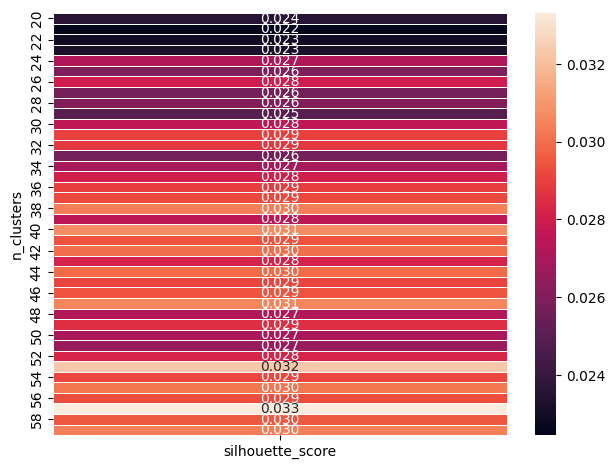

In [441]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt


# 문서를 명사 집합으로 보고 문서 리스트로 치환 (tfidfVectorizer 인풋 형태를 맞추기 위해)
text = [" ".join(noun) for noun in df['nouns']]

tfidf_vectorizer = TfidfVectorizer(min_df = 5, ngram_range=(1,5))
tfidf_vectorizer.fit(text)
vector = tfidf_vectorizer.transform(text).toarray()

# 베스트 k찾기
data=vector
param_init='random'
param_n_init=10
param_max_iter=100

clusters_range = range(20,40)
results = []

for i in tqdm(clusters_range):
    clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
    cluster_labels = clusterer.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    results.append([i, silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

plt.figure()
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
plt.tight_layout()
plt.show()



In [442]:
# 학습
k = 24

clusterer = KMeans(n_clusters=k, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
df['cluster'] = clusterer.fit_predict(data)

In [443]:
# 키워드 뽑기
from keybert import KeyBERT

key_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')  #distilbert-base-nli-mean-tokens / paraphrase-multilingual-MiniLM-L12-v2
result = []
def keyword(data):  #data = cluster_result (데이터프레임) #1분 30초 소요됨
    for i in tqdm(range(k)):
        key_text = df[df['cluster']==i]['nouns'].apply(lambda x: ' '.join(x))
        key_text = ' '.join(key_text)
        keyword = key_model.extract_keywords(key_text, keyphrase_ngram_range=(1,3), top_n=1)
        result.append(keyword[0][0])
    return result

keyword(df)

100%|███████████████████████████████████████████| 24/24 [01:58<00:00,  4.93s/it]


['광학 필터 가시광선',
 '인증 광학 의료기기',
 '체렌코프 방사선 광학',
 '생체 영상 최적화',
 '연구기관 보유 장비',
 '인식 이미지 데이터베이스',
 '블루 레이저 스마트',
 '유기 반응 방법론',
 '반응 액정 화합물',
 '위성 탑재 전자광학',
 '광섬유 센서 음향',
 '세포 형광 염료',
 '합성 비선형 광학',
 '렌즈 공정 웨이퍼',
 '세포 형광 나노입자',
 '나노 물질 센서',
 '전극 나노 투명전극',
 '응집물질 양자화',
 '광학 코팅 소재',
 '광학 소자 디스플레이',
 '광학 나노기술 광학',
 '자외선 근접 나노',
 '소용돌이 레이저 비선형광학',
 '필터 나노 프린트']

In [444]:
def merge_keyword(data): #새 열로 추가.

    data_temp = data.copy()

    for i in range(len(data)):
        group = data['cluster'][i]
        data['cluster_keyword'][i]=result[group]
    return data_temp
    
df['cluster_keyword']=None
keyword_result = merge_keyword(df)


/var/folders/6f/wt1hg08n5sb50q6jvjn2m1gm0000gn/T/ipykernel_19364/1458456131.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster_keyword'][i]=result[group]
/var/folders/6f/wt1hg08n5sb50q6jvjn2m1gm0000gn/T/ipykernel_19364/1458456131.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster_keyword'][i]=result[group]
/var/folders/6f/wt1hg08n5sb50q6jvjn2m1gm0000gn/T/ipykernel_19364/1458456131.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [445]:
df.to_excel('result.xlsx')

In [458]:
result_edited = pd.read_excel('result_edited.xlsx', sheet_name='Sheet1', engine='openpyxl')
final=df_sheet_origin.copy()
keywords_dict = {
    '광학 가시광선 필터': 0,
    '광학적 검사를 이용한 의료기기': 1,
    '체렌코프 방사선 영상 광학': 2,
    '생체 영상 최적화': 3,
    '광학적 이미지 인식': 4,
    '블루 레이저': 5,
    '유기 반응 방법론': 6,
    '반응 액정 화합물': 7,
    '위성 전자광학': 8,
    '광섬유': 9,
    '세포 형광 염료 나노입자': 10,
    '비선형광학': 11,
    '광학 렌즈 공정': 12,
    '나노 물질 센서': 13,
    '나노 전극': 14,
    '양자광학': 15,
    '광학 필름': 16,
    '홀로그래픽': 17,
    '광학 나노기술': 18,
    '자외선 근접 나노': 19,
    '필터 나노 프린트': 20
}

for i, row in final.iterrows():
    title = row['Title']
    cluster_keyword = result_edited.loc[df['Title'] == title, 'cluster_keyword'].values[0]
    final.at[i, 'Cluster_keyword'] = cluster_keyword
    final.at[i, 'Cluster'] = keywords_dict[cluster_keyword]
final


Title  Project ID  \
0     고굴절 칼코지나이드 유리를 이용한 웨이퍼레벨 기반 모바일용 초소형광학모듈 상용화 기...  1711154094   
1                           정지궤도위성용 미래형 전자광학탑재체 핵심기술 개발  1711075898   
2                                   FPD용 고내열광학기능성 필름 개발  1415077488   
3                                   초정밀광학렌즈용 금형 코팅기술 개발  1345084968   
4                                      나노광학소자용 패터닝 공정기술  1350011674   
5             고밀도 배선 PCB 최종 검사를 위한 차세대 지능형 자동광학검사시스템 개발  1425103341   
6                              융복합광학기술을 응용한 진단치료기기 실증지원  1465033817   
7      자외선 근접장 나노광학현미경의 개발 및 이를 이용한 자외선 근접장 라만산란 분석기술개발  1345101255   
8                             광학활성 라베프라졸 및 이를 이용한 제제 개발  1415126958   
9           자외선근접장나노광학현미경의 개발 및 이를 이용한 자외선근접장라만산란분석기술개발  1355048988   
10                   금속성 단일 나노입자를 이용한광학센서로의 환경 기반 기술 개발  1485007039   
11             Nano PIV 와 세포단위의 혈류 가시화를 위한 Bio광학시스템의 개발  1345103423   
12    서브m급 고해상도광학탑재체 성능 향상을 위한 모듈화된 하이브리드형 미세진동 절연장치 개발  1345157634   
13                            경사입사증착을 이용한 나노구조광학박막소자 연구  1345128137   
14                            초박형 디스플레이용 고기능성 다층광학시트 개발  1415147874   
15          광반응성 고분자에서의 빛의 간섭현상을 이용한 정보저장 및 나노광학소자로의 응용  1345141754   
16                         고감도 반도체광학센서 기반의 지능형 집적시스템 개발  1711068641   
17                              광학센싱 활용 통합 인지서킷 프로그램 개발  1485011529   
18                    혁신적 나노소재 및 미래형 나노전자/광학소자의 설계 및 개발  1345110464   
19    크리스퍼/디캐스9 과 바이오광학센서를 접목한 병원체 검출 민감도 및 특이도 향상을 ...  1711067808   
20                     물체 상면과 측면의 동시 촬영이 가능한 산업용광학렌즈 개발  1425102204   
21     자외선 근접장 나노광학현미경의 개발 및 이를 이용한 자외선 근접장 라만산란 분석기술개발  1345121849   
22    무안경식 차세대 3D 디스플레이를 위한 빛의 세기 및 위상변조에 반응하는 신개념광학...  1345246068   
23                         트랜스아미나제를 이용한광학활성 비천연아미노산의 생산  1345128944   
24                                    양자정보및디스플레이광학연구사업팀  1345071286   
25      글래스 인터포저를 위한 비선형 레이저 흡수 기반의 고속 TGV 공정 및광학시스템 개발  1415177626   
26                           광학기반 다채널 고정밀 세포대사 측정시스템 개발  1425094699   
27                        터치패널용 내지문/내오염성 및 투명전도성광학필름 개발  1425069722   
28    두-모드 간섭효과와 감지도 최적화를 위한 전산모사를 이용한 집적광학소산파 바이오센서...  1345281347   
29                 인후부 조직 축소용광학영상 가이드 고강도 집속 초음파 수술기 개발  1415174829   
30                         자동차 디스플레이용 고시인성광학위상차 필름소재 개발  1415168755   
31    (총괄)디지털 홀로그램 윈도우 재현 기술개발, (세부1)광학시뮬레이션을 이용한 디지...  1711159682   
32                        5G 연계 고시인성 광시야 AR광학모듈 핵심기술 개발  1415184318   
33                        체열진단을 위한 저가보급형 열화상카메라용광학렌즈 개발  1425072101   
34                                    양자정보및디스플레이광학연구사업팀  1340013657   
35                        다중 레이저 다이오드를 이용한광학결함 검사 장치 개발  1425083150   
36             저가형 고신뢰성 라이다 빔 쉐이핑광학부품 일괄 제조공정 및 양산기술 개발  1711101956   
37                            광학센서 기반의 반려견 비문 인식 시스템 개발  1415154892   
38      플라즈마 애싱을 이용한광학필름용 Roll-to-Roll 건식 복합 초음파 세정기 개발  1415117177   
39                                          광학시스템 기술 개발  1415108583   
40      초정밀 3차원 전자빔 리소그래피 기반 3차원 메타물질 제작 및광학특성과 역학특성 연구  1711027559   
41            광학이미지 획득방법을 이용하는 반도체 패턴 미소결함 고속 검사장비 기술개발  1711026115   
42                       체렌코프광학영상을 활용한 방사화학적 순도 측정기술 개발  1711026247   
43                             Lead-Free 통신용 박막광학필터 패키징  1420020850   
44                  고효율 LED Lamp용광학렌즈 생산을 위한 고생산성 금형 개발  1415133123   
45             광학인증(OID) 펜을 활용한 무선방식의 양방향 음성인식 어학학습기 개발  1425069065   
46                                    전방위광학렌즈 및광학시스템 개발  1425074486   
47     적외선 웨이퍼레벨광학계(Wafer Level Optics)용광학유리소재 및광학모듈 개발  1711120266   
48       악성종양의 융합분자영상(방사선 및광학)을 위한 신생혈관 표적 ELR 펩타이드의 개발  1345239924   
49                         그래핀 메타물질에서 초고속 테라헤르츠 비선형광학생성  1345246369   
50           적외선광학가스 영상을 이용한 호흡기 질환 진단 및 헬스 모니터링 시스템 개발  1711110812   
51    당뇨병성 신경병증 치료원료의 국산화를 위한 라세미티옥트산의광학이성질체 분리기술 및 ...  1425158504   
52                                   신경조직 검출광학현미경 모듈 개발  1425115383   
53            (참여3)초고속광학진단 및 수술용 전 광 파장가변 레이저 모듈 상용화 개발  1711138044   
54    블루레이저를 이용한 스마트 솔더링광학엔진 기반의 카메라모듈패키징용 젯솔더링 장비 실증개발  1415171802   
55              광학보정 기술이 적용된 석정반 기반이 아닌 11세대용 gantry 개발  1425120877   
56 

In [459]:
final.to_excel('final_중복o_광학o.xlsx')